In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df

,project,language,commits,insertions,age,bugs,project_type,devs
0,4clojure,Clojure,629,9180,774,128,Application,21
1,4clojure,Javascript,75,39240,509,29,Application,10
2,AFIncrementalStore,Objective-C,196,5624,362,74,Library,24
3,AFNetworking,Objective-C,952,50099,962,403,Framework,128
4,ActionBar-PullToRefresh,Java,213,14657,192,68,Library,5
...,...,...,...,...,...,...,...,...
1122,zipkin,Scala,245,54100,589,207,Application,8
1123,zombie,Coffeescript,731,52668,1060,181,Framework,65
1124,zombie,Javascript,46,172564,1026,7,Framework,7
1125,zxcvbn,Coffeescript,58,2085,341,11,Library,5


We define the dataset as an xarray aswell, so it fits PyMC.

In [4]:
df_xa = df.to_xarray()

In [5]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

## Hypothesis 2 (w Normal Dist.)

* **H2** - Age (A) has a positive impact on number of bugs (B) for all programming languages (L). That is, projects of old age (A) have larger number of bugs (B). 

This time we attempt to model Hypothesis 2 in a normal distribution manner by also standardizing number of bugs (B). We believe that this implementation at least gives us a better interpretation.

The model is defined as follows:

$$B_i \sim \mathrm{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_{\mathrm{A}[LID]} A_i$$
$$\sigma  = \text{To be determined}$$
$$\alpha  = \text{To be determined}$$
$$\beta_{\mathrm{A}[LID]} = \text{To be determined}$$


where 
$$LID \in \mathcal{LID}$$
$$\mathcal{LID} = \text{Python,Java..,C}$$    
$$|\mathcal{LID}|=17 $$


As for the prior for $\sigma$, $\alpha$, and $\beta_{\mathrm{A}[LID]}$, we'll set plausible values in the next section.

In [6]:
def standardize_column(variable):
    # Standardize the column
    standardized_column = (variable - variable.mean()) / variable.std()
    
    return standardized_column

In [7]:
df['age_std'] = standardize_column(df['age'])

In [8]:
df['bugs_std'] = standardize_column(df['bugs'])

In [9]:
language_idx, languages = pd.factorize(df.language)

### Determine priors 

* Determine prior $\alpha$ and $\sigma$ 

Assuming that an age value takes 0, you expect the corresponding bugs to be 0 as well. We thereby set the $\alpha$ mean to 0. 

As for the $\alpha$ std and $\sigma$, we'll make adjustments so that # of bugs follows reasonable values with the $\beta_{\mathrm{A}[LID]}$ std. 


* Determine prior  $\beta_{\mathrm{A}[LID]}$

Based on the DAGs, we speculate the $\beta_{\mathrm{A}[LID]}$ mean to have no effect on bugs, i.e. the mean set to 0. 

In [72]:
with pm.Model() as h2_normal_model:
    alpha = pm.Normal("alpha", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.2, shape=languages.size)
    sigma = pm.Exponential("sigma", 1.0)

    #We add language_ids and age_std as mutable data so we can change it later in posterior predictions
    language_ids = pm.Data('language_ids', language_idx, mutable=True)
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    
    # Note the "deterministic" distribution node, 
    # that basically encodes equality from the mathematical model
    mu = pm.Deterministic("mu", 
                alpha + bA[language_ids] * age_std)

    # B = Number of Bugs Standardized
    B = pm.Normal("B", mu = mu, sigma = sigma, observed = df.bugs_std.values)
    
    # prior predictive is a distribution of data 
    # (but for each data point we also get its parameters so we can plot various regression lines we are getting)
    h2_normal_trace = pm.sample_prior_predictive(samples = 500, random_seed = rng)
    
    # idata stands for 'inference data'. Each sampler returns its own inference data object, and there is no serious need
    # to mix them.  For convenience we use the extend method, to keep all samples in one object.
    h2_normal_trace.extend(pm.sample(random_seed = rng, idata_kwargs={"log_likelihood": True}))

Sampling: [B, alpha, bA, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


(-2.0, 2.0)

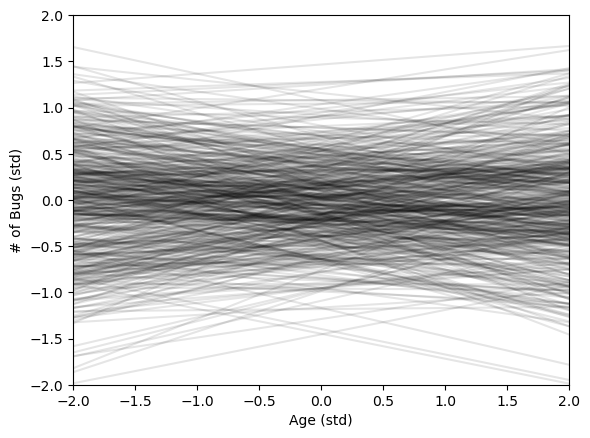

In [73]:
# The index 0 gives us the first chain 
# (there is only one chain for the prior anyway)
alpha_  = h2_normal_trace.prior.alpha[0]
bA_ = h2_normal_trace.prior.bA[0][:,0]

fig, ax = plt.subplots()
# We use xArray, as multiplication of numpy and pandas does not do what we need
xx  = xr.DataArray(np.linspace(-2, 2, 3), dims="plot_dim")
# xr does some weird matching, but effectively plus is pointwise 
# and multiplication is bA_.T * xx (so matrix multiplication with the first argument transposed)
# We get an array of rows (one per sample from the prior) and the rows contain the three points 
# (the size of xx)
yy  = alpha_ + bA_ * xx
# transpose yy, because matplotlib wants it this way.
ax.plot(xx, yy.T, c = "k", alpha = 0.1)
    
ax.set_xlabel("Age (std)")
ax.set_ylabel("# of Bugs (std)")
ax.set_ylim(-2.0, 2.0)
ax.set_xlim(-2.0, 2.0)

The result looks fairly reasonable. Most lines are more or less flat and center around the value 0 for bugs. This reflects our assumption that each entry of age doesn't have any direct influence on number of bugs. 

We thereby proceed with $\beta_{\mathrm{A}[LID]} \sim \mathrm{Normal}(0, 0.2)$.

### Modelling

We update the model as follows:

$$B_i \sim \mathrm{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_{\mathrm{A}[LID]} A_i$$
$$\sigma \sim \mathrm{Exp}(1)$$
$$\alpha \sim \mathrm{Normal}(0, 0.5)$$
$$\beta_{\mathrm{A}[LID]} \sim \mathrm{Normal}(0, 0.2)$$

where 
$$LID \in \mathcal{LID}$$
$$\mathcal{LID} = \text{Python,Java..,C}$$    
$$|\mathcal{LID}|=17 $$

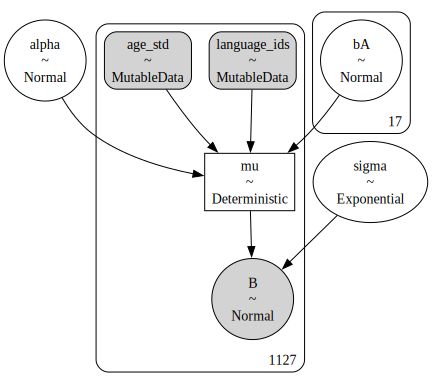

In [12]:
pm.model_graph.model_to_graphviz(h2_normal_model)

In [74]:
#specifying names of the variables
var_names_langauge = list(h2_normal_trace.posterior.data_vars.keys())[:-1]
pm.summary(h2_normal_trace, var_names=var_names_langauge,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.02,0.03,-0.08,0.03,0.0,0.0,6927.37,2874.18,1.0
bA[0],0.04,0.15,-0.25,0.32,0.0,0.0,9465.51,2791.49,1.0
bA[1],0.03,0.05,-0.07,0.13,0.0,0.0,7390.40,3253.49,1.0
bA[2],0.02,0.14,-0.24,0.29,0.0,0.0,9861.60,3080.33,1.0
bA[3],0.06,0.12,-0.18,0.28,0.0,0.0,9365.78,2973.70,1.0
bA[4],0.17,0.11,-0.03,0.39,0.0,0.0,7908.63,3001.67,1.0
bA[5],0.45,0.13,0.19,0.69,0.0,0.0,7484.14,2853.61,1.0
bA[6],-0.02,0.11,-0.22,0.18,0.0,0.0,8094.74,2980.99,1.0
bA[7],0.50,0.07,0.37,0.63,0.0,0.0,7356.66,2793.00,1.0
bA[8],0.16,0.09,-0.00,0.32,0.0,0.0,8593.74,2797.83,1.0


Overall, the model seemed to converge well. 
We have 1. a high number of `ess_bulk` and `ess_tail`, 2. `mcse_mean` and `mcse_sd` = 0.0, and 3. `r_hat` = 1.0.

We conclude that we can proceed with this posterior.

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

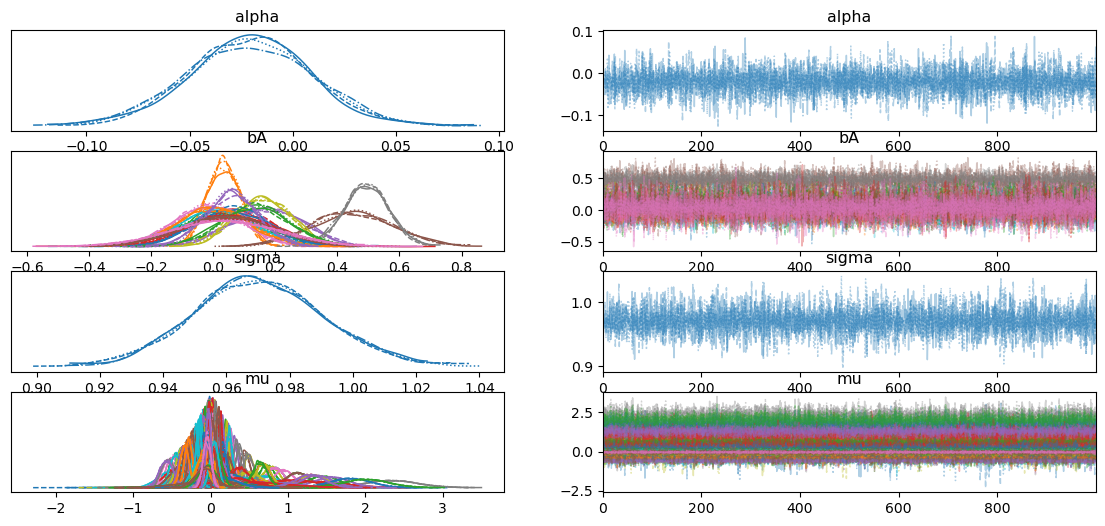

In [14]:
az.plot_trace(h2_normal_trace, figsize=(14, 3*2))

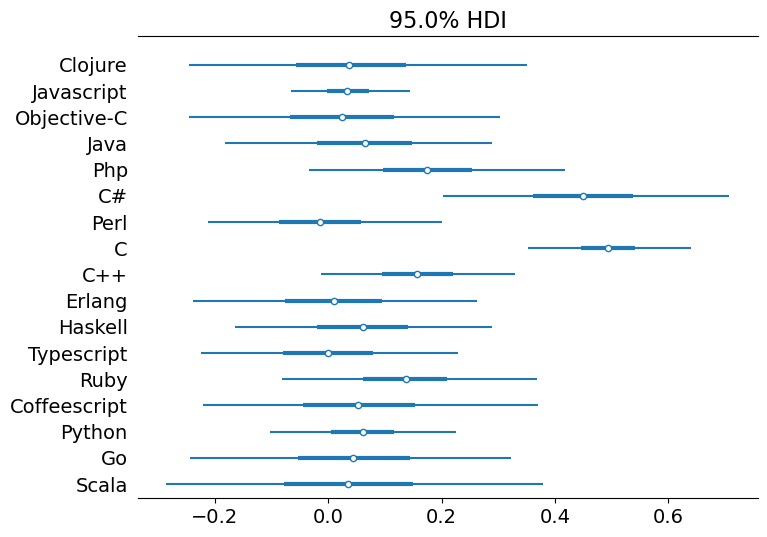

In [56]:
#pm.plot_forest(h2_normal_trace, var_names=['alpha','bA'], hdi_prob=.95, combined=True);
_,ax = plt.subplots(figsize=(8,6))
pm.plot_forest(h2_normal_trace, var_names=['bA'], hdi_prob=.95, combined=True, ax=ax);
forest_languages = list(range(16, -1, -1))
ax.set_yticklabels(languages.take(forest_languages));

Base on the summary and forest plot, the effect of age for many languages features a wide range of HDI that crosses 0, suggesting that these estimates are not reliable enough.

While `C#` and `C` languages are estimated to have a positive impact on bugs, we speculate that it's due to the ommited-variable bias.

### Posterior predictive check

Finally, we perform posterior predictive check to see if the model fits the data well.

Due to the model restriction, we visualize the results per language. We sampled $1127$ points from `age_std` values between $-1.5$ to $5$ given a specified language.

In [16]:
languages

Index(['Clojure', 'Javascript', 'Objective-C', 'Java', 'Php', 'C#', 'Perl',
       'C', 'C++', 'Erlang', 'Haskell', 'Typescript', 'Ruby', 'Coffeescript',
       'Python', 'Go', 'Scala'],
      dtype='object')

In [79]:
print(df[df['language']=='Perl'].age_std.min())
print(df[df['language']=='Perl'].age_std.max())

-0.9181804910047063
3.1876957819621703


In [75]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)

with h2_normal_model:
    pm.set_data({"age_std": x_seq, "language_ids": np.repeat(6, n_points)})
    post_pred_B_h2 = pm.sample_posterior_predictive(h2_normal_trace, var_names=["B"])['posterior_predictive']['B']
    
post_pred_B_h2_mean = post_pred_B_h2.mean(["chain", "draw"])

Sampling: [B]


The results for Perl language is shown below.

* We see a near flat line at `bug_std` = 0. This disproves **H2** and indicates that regardless of projects' age, the standardized bugs get an expected value of 0. 
* The posterior also seem to take a wide range of value from -2.0 to 2.0. The model doesn't fit to these data points well.


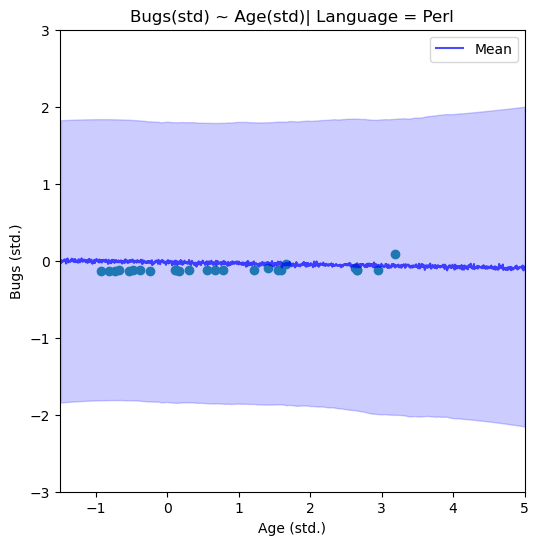

In [76]:
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B_h2, color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_h2_mean, color = 'b', alpha=0.7, label='Mean')
plt.scatter(df[df['language']=='Perl'].age_std, df[df['language']=='Perl'].bugs_std)

plt.legend()
plt.xlim(-1.5,5.0)
#plt.ylim(0,20000)
plt.ylim(-3.0,3.0)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs (std.)')
plt.title("Bugs(std) ~ Age(std)| Language = Perl");

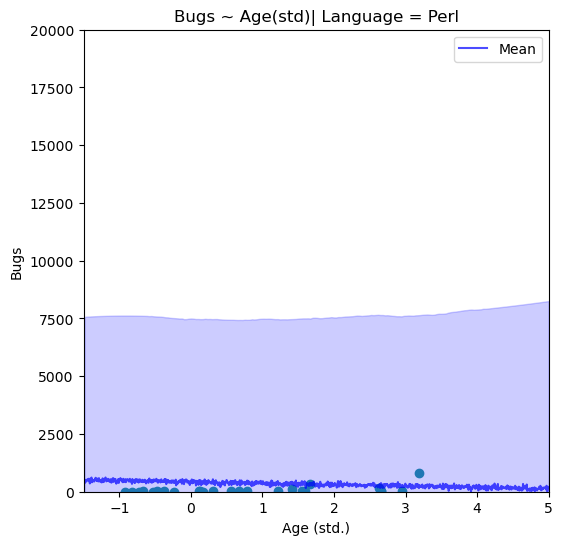

In [77]:
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B_h2*df.bugs.std()+df.bugs.mean(), color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_h2_mean*df.bugs.std()+df.bugs.mean(), color = 'b', alpha=0.7, label='Mean')
plt.scatter(df[df['language']=='Perl'].age_std, df[df['language']=='Perl'].bugs)

plt.legend()
plt.xlim(-1.5,5.0)
plt.ylim(0,20000)
#plt.ylim(-3.0,3.0)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs')
plt.title("Bugs ~ Age(std)| Language = Perl");

### Conclusion H2

Based on the results, we still reject **H2** and conclude that age doesn't have a positive effect for *all* languages.

`C#` and `C` languages are estimated with a positive coefficient, except we believe it is caused by the afore-mentioned bias.

## Hypothesis 3 (w Normal Dist.)

* **H3** - Number of commits (C) does not impact the effect of age (A) on the number of bugs (B) for any programming language (L). That is, the effect of age (A), conditioned on number of commits (C), on number of bugs (B) is the same as the direct effect of age (A) on number of bugs (B).

We condition the effect of age by including number of commits in the model. As showed in the DAGs prior, we believe that this change will remove any "effect" we saw for age on number of bugs.

The model is defined as follows:

$$B_i \sim \mathrm{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_{\mathrm{A}[LID]} A_i + \beta_{\mathrm{C}[LID]} C_i$$
$$\sigma \sim \mathrm{Exp}(1)$$
$$\alpha \sim \mathrm{Normal}(0, 0.5)$$
$$\beta_{\mathrm{A}[LID]} \sim \mathrm{Normal}(0, 0.2)$$
$$\beta_{\mathrm{C}[LID]} = \text{To be determined}$$

where 
$$LID \in \mathcal{LID}$$
$$\mathcal{LID} = \text{Python,Java..,C}$$    
$$|\mathcal{LID}|=17 $$

As for the prior for $\sigma$, $\alpha$, and $\beta_{\mathrm{A}[LID]}$, we set the same parameter as **H2**.

In [20]:
df['commits_std'] = standardize_column(df['commits'])

### Determine priors

* Determine prior  $\beta_{\mathrm{L}[LID]}$

Based on the DAGs, we expect the $\beta_{\mathrm{C}[LID]}$ mean to have a positive effect on number of bugs. We will decide on the hyper-parameters accordingly.

In [33]:
with pm.Model() as h3_normal_model:
    alpha = pm.Normal("alpha", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.2, shape=languages.size)
    bC = pm.Normal("bC", 1, 0.2, shape=languages.size)
    sigma = pm.Exponential("sigma", 1)

    #We add language_ids and age_std, com_std as mutable data so we can change it later in posterior predictions
    language_ids = pm.Data('language_ids', language_idx, mutable=True)
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    commits_std = pm.Data("commit_std", df.commits_std, mutable=True)
    
    # Note the "deterministic" distribution node, 
    # that basically encodes equality from the mathematical model
    mu = pm.Deterministic("mu", 
                alpha + bA[language_ids] * age_std + bC[language_ids] * commits_std)

    # B = Number of Bugs Standardized
    B = pm.Normal("B", mu = mu, sigma = sigma, observed = df.bugs_std.values)
    
    # prior predictive is a distribution of data 
    # (but for each data point we also get its parameters so we can plot various regression lines we are getting)
    h3_normal_trace = pm.sample_prior_predictive(samples = 500, random_seed = rng)
    
    # idata stands for 'inference data'. Each sampler returns its own inference data object, and there is no serious need
    # to mix them.  For convenience we use the extend method, to keep all samples in one object.
    h3_normal_trace.extend(pm.sample(random_seed = rng, idata_kwargs={"log_likelihood": True}))

Sampling: [B, alpha, bA, bC, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, bC, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


(-2.0, 2.0)

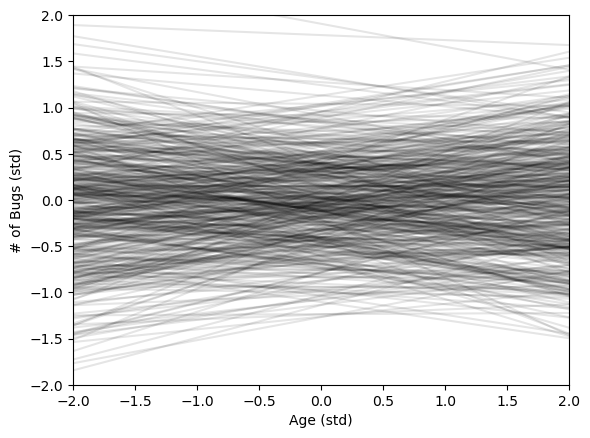

In [34]:
# The index 0 gives us the first chain 
# (there is only one chain for the prior anyway)
alpha_  = h3_normal_trace.prior.alpha[0]
bA_ = h3_normal_trace.prior.bA[0][:,0]
bC_ = h3_normal_trace.prior.bC[0][:,0]

fig, ax = plt.subplots()
# We use xArray, as multiplication of numpy and pandas does not do what we need
xx  = xr.DataArray(np.linspace(-2, 2, 3), dims="plot_dim")
# xr does some weird matching, but effectively plus is pointwise 
# and multiplication is bA_.T * xx (so matrix multiplication with the first argument transposed)
# We get an array of rows (one per sample from the prior) and the rows contain the three points 
# (the size of xx)
yy  = alpha_ + bA_ * xx
# transpose yy, because matplotlib wants it this way.
ax.plot(xx, yy.T, c = "k", alpha = 0.1)
    
ax.set_xlabel("Age (std)")
ax.set_ylabel("# of Bugs (std)")
ax.set_ylim(-2.0, 2.0)
ax.set_xlim(-2.0, 2.0)

(-2.0, 2.0)

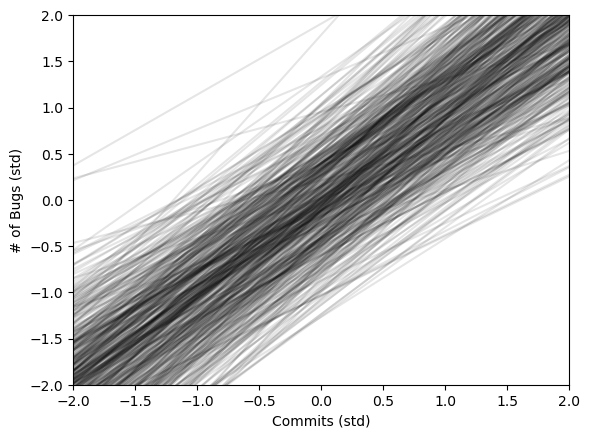

In [35]:
# The index 0 gives us the first chain 
# (there is only one chain for the prior anyway)
alpha_  = h3_normal_trace.prior.alpha[0]
bC_ = h3_normal_trace.prior.bC[0][:,0]

fig, ax = plt.subplots()
# We use xArray, as multiplication of numpy and pandas does not do what we need
xx  = xr.DataArray(np.linspace(-2, 2, 3), dims="plot_dim")
# xr does some weird matching, but effectively plus is pointwise 
# and multiplication is bA_.T * xx (so matrix multiplication with the first argument transposed)
# We get an array of rows (one per sample from the prior) and the rows contain the three points 
# (the size of xx)
yy  = alpha_ + bC_ * xx
# transpose yy, because matplotlib wants it this way.
ax.plot(xx, yy.T, c = "k", alpha = 0.1)
    
ax.set_xlabel("Commits (std)")
ax.set_ylabel("# of Bugs (std)")
ax.set_ylim(-2.0, 2.0)
ax.set_xlim(-2.0, 2.0)

These results looks fairly reasonable. Most lines are more or less flat for age and have a positive slope for number of commits. They reflect our assumption that number of commits has a positive impact on bugs and age does not.

We thereby proceed with $\beta_{\mathrm{C}[LID]} \sim \mathrm{Normal}(1, 0.2)$.

### Modelling

We update the model as follows:

$$B_i \sim \mathrm{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_{\mathrm{A}[LID]} A_i + \beta_{\mathrm{C}[LID]} C_i$$
$$\sigma \sim \mathrm{Exp}(1)$$
$$\alpha \sim \mathrm{Normal}(0, 0.5)$$
$$\beta_{\mathrm{A}[LID]} \sim \mathrm{Normal}(0, 0.2)$$
$$\beta_{\mathrm{C}[LID]} \sim \mathrm{Normal}(1, 0.2)$$

where 
$$LID \in \mathcal{LID}$$
$$\mathcal{LID} = \text{Python,Java..,C}$$    
$$|\mathcal{LID}|=17 $$

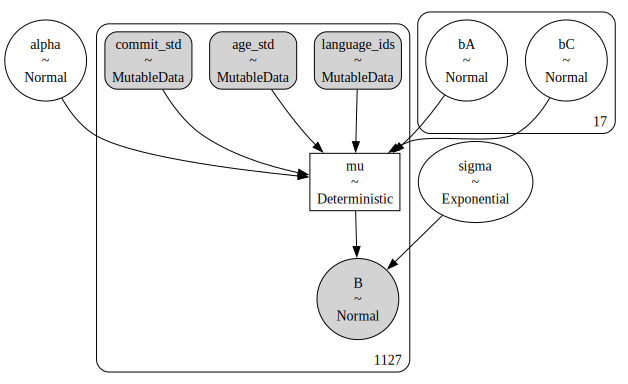

In [36]:
pm.model_graph.model_to_graphviz(h3_normal_model)

In [37]:
#specifying names of the variables
var_names_langauge = list(h3_normal_trace.posterior.data_vars.keys())[:-1]
pm.summary(h3_normal_trace, var_names=var_names_langauge,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.01,0.00,-0.01,-0.00,0.0,0.0,4721.70,2870.22,1.00
bA[0],-0.00,0.02,-0.05,0.04,0.0,0.0,4823.27,3082.51,1.00
bA[1],0.01,0.01,-0.00,0.02,0.0,0.0,5182.64,2797.55,1.00
bA[2],0.00,0.02,-0.03,0.03,0.0,0.0,4881.14,3252.08,1.00
bA[3],-0.02,0.01,-0.04,0.01,0.0,0.0,7021.24,2970.76,1.00
bA[4],0.01,0.01,-0.02,0.03,0.0,0.0,5209.12,3130.34,1.00
bA[5],0.01,0.02,-0.03,0.04,0.0,0.0,4170.45,3095.75,1.00
bA[6],0.01,0.01,-0.01,0.03,0.0,0.0,6320.84,3069.31,1.00
bA[7],0.04,0.01,0.03,0.05,0.0,0.0,6309.37,3378.78,1.00
bA[8],0.01,0.01,-0.01,0.03,0.0,0.0,5511.13,3498.50,1.00


Overall, the model still seemed to converge well. 
We get 1. a high number of `ess_bulk` and `ess_tail`, 2. `mcse_mean` and `mcse_sd` = 0.0, and 3. `r_hat` = 1.0. for all.

We conclude that we can proceed with this posterior.

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'bC'}>, <Axes: title={'center': 'bC'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

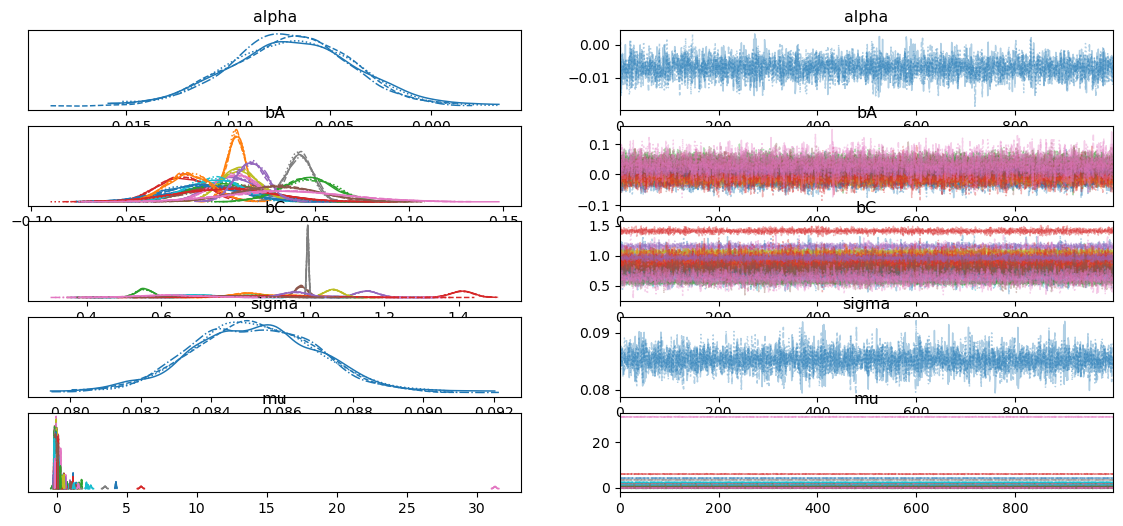

In [38]:
az.plot_trace(h3_normal_trace, figsize=(14, 3*2))

Text(0, 0.5, '$\\beta_{\\mathrm{A}}$')

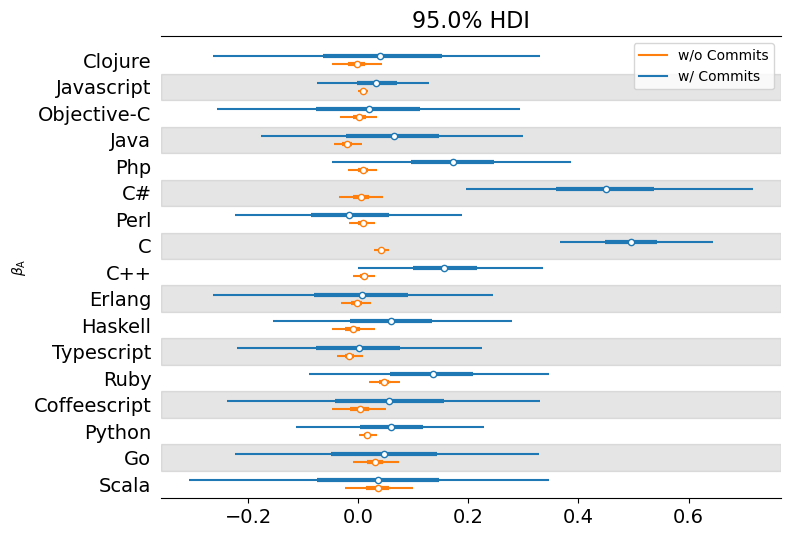

In [85]:
_,ax = plt.subplots(figsize=(8,6))
pm.plot_forest((h2_normal_trace, h3_normal_trace), model_names=['w/ Commits', 'w/o Commits'],var_names=['bA'], hdi_prob=.95, combined=True, ax=ax);
forest_languages = list(range(16, -1, -1))
ax.set_yticklabels(languages.take(forest_languages));
ax.set_ylabel(r"$\beta_{\mathrm{A}}$")

Text(0, 0.5, '$\\beta_{\\mathrm{C}}$')

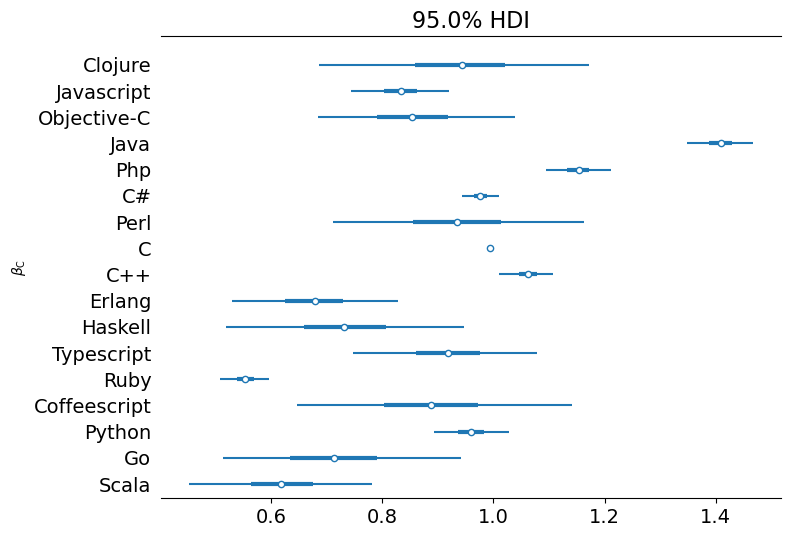

In [86]:
#pm.plot_forest(h3_normal_trace, var_names=['alpha','bA', 'bC'], hdi_prob=.95, combined=True);
#forest_languages = list(range(17))
#ax.set_yticklabels(languages.take(forest_languages));

_,ax = plt.subplots(figsize=(8,6))
pm.plot_forest(h3_normal_trace, var_names=['bC'], hdi_prob=.95, combined=True, ax=ax);
forest_languages = list(range(16, -1, -1))
ax.set_yticklabels(languages.take(forest_languages));
ax.set_ylabel(r"$\beta_{\mathrm{C}}$")

After conditioned on number of commits, the effect of age is pulled even closer towards 0 with a shorter HDI. Instead, we see all $\beta_{\mathrm{C}[LID]}$ get a positive coefficient with high confidence.　

We see a strong evidence that disproves **H3**. This result aligns with our assumption that it follows a fork-shaped DAG, which explains the ommited-variable bias we mentioned earlier.

### Posterior predictive check

Again, we do posterior predictive check to see the model fit.

Due to the model restriction, we can only visualize the results per language. We sampled $1127$ points from `age_std` values between $-1.5$ to $5$ given a specified language.

In [41]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)

with h3_normal_model:
    pm.set_data({"age_std": x_seq, "commit_std": np.repeat(0, n_points), "language_ids": np.repeat(6, n_points)})
    post_pred_B_h3 = pm.sample_posterior_predictive(h3_normal_trace, var_names=["B"])['posterior_predictive']['B']
    
post_pred_B_h3_mean = post_pred_B_h3.mean(["chain", "draw"])

Sampling: [B]


The results for Perl language is shown below.

* We still see a near flat line (green) at `bug_std` = 0. This indicates that regardless of projects' age, the standardized bugs get an expected value of 0. 
* The new posterior takes a shorter HDI (green), which makes us more certain about the age effect being close to none. 

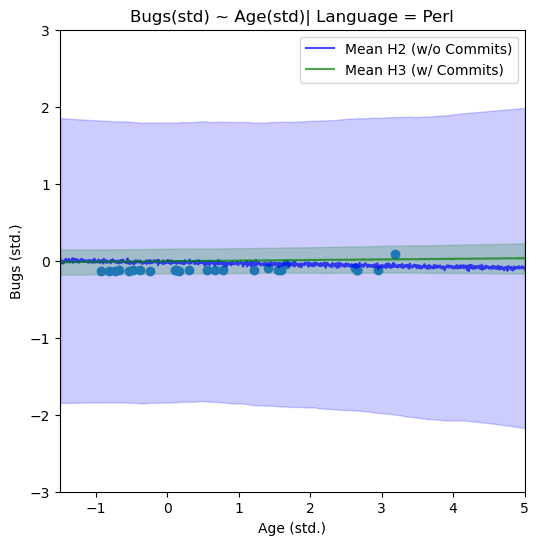

In [42]:
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B_h2, color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_h2_mean, color = 'b', alpha=0.7, label='Mean H2 (w/o Commits)')
az.plot_hdi(x_seq, post_pred_B_h3, color = 'g', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_h3_mean, color = 'g', alpha=0.7, label='Mean H3 (w/ Commits)')
plt.scatter(df[df['language']=='Perl'].age_std, df[df['language']=='Perl'].bugs_std)

plt.legend()
plt.xlim(-1.5,5.0)
#plt.ylim(0,20000)
plt.ylim(-3.0,3.0)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs (std.)')
plt.title("Bugs(std) ~ Age(std)| Language = Perl");

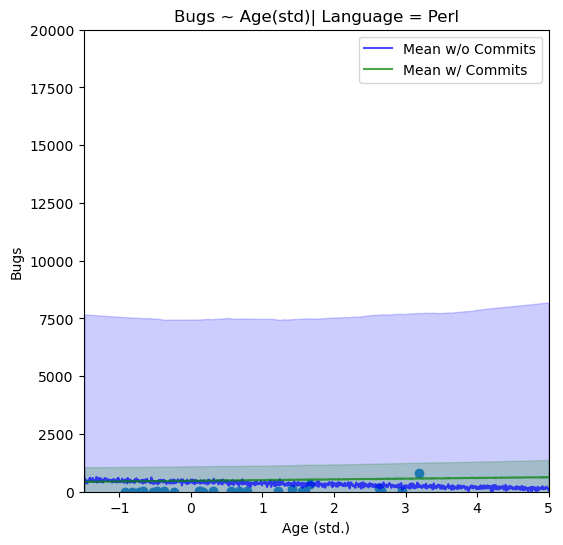

In [43]:
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B_h2*df.bugs.std()+df.bugs.mean(), color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_h2_mean*df.bugs.std()+df.bugs.mean(), color = 'b', alpha=0.7, label='Mean w/o Commits')
az.plot_hdi(x_seq, post_pred_B_h3*df.bugs.std()+df.bugs.mean(), color = 'g', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_h3_mean*df.bugs.std()+df.bugs.mean(), color = 'g', alpha=0.7, label='Mean w/ Commits')
plt.scatter(df[df['language']=='Perl'].age_std, df[df['language']=='Perl'].bugs)

plt.legend()
plt.xlim(-1.5,5.0)
plt.ylim(0,20000)
#plt.ylim(-3.0,3.0)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs')
plt.title("Bugs ~ Age(std)| Language = Perl");

### Conclusion H3

Based on the results, we could reject **H3** and conclude that conditioned by commits, age doesn't have a positive effect on number of bugs for *any* languages.

While we believe that this reflects our assumption about the DAGs, more investigations may be required as to why we get the opposite results on **H3** with the poisson model.

## Model comparison (w Normal Dist.)

Lastly, we compare the two normal distribution models. 

We see that the **H3** model where we conditioned age with number of commits performed better than the other as expected.

/Users/eisukeokuda/ENTER/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/eisukeokuda/ENTER/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/eisukeokuda/ENTER/env

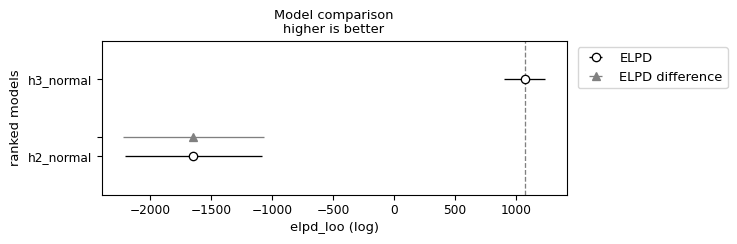

In [45]:
comp = pm.compare({'h2_normal': h2_normal_trace,
                   'h3_normal': h3_normal_trace})

pm.plot_compare(comp, insample_dev=False);